<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.



## Подготовка

In [1]:
#импорты необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as mse

In [2]:
#прочитаем и посмотрим на первые 5 строк датафрейма
df = pd.read_csv('/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
#посмотрим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
#переведем столбец с датами в формат datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
#установим индекс таблицы равным столбцу Datetime
df.set_index('datetime', inplace=True)

In [6]:
#отсортируем и проверим, в хронологическом ли порядке расположены даты и время
df = df.sort_index()
df.index.is_monotonic

True

In [7]:
#сделаем ресемплирование по 1 часу
df_resampled = df.resample('1H').sum()
df_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Вывод:
1. Прочитали датафрейм
2. Перевели в другой формат столбец с датами заказов
3. Установили индекс таблицы равным столбцу DateTime
4. Отсортировали и проверили хронологию столбца с датами заказов
5. Сделали ресемплирование по 1 часу

## Анализ

Посмотрим на минимальные и максимальные значения

In [8]:
display("начало:",df.index.min())
display("конец:",df.index.max())

'начало:'

Timestamp('2018-03-01 00:00:00')

'конец:'

Timestamp('2018-08-31 23:50:00')

Получается данные у нас с 01 марта 2018 года по 31 августа 2018 года (6 месяцев)

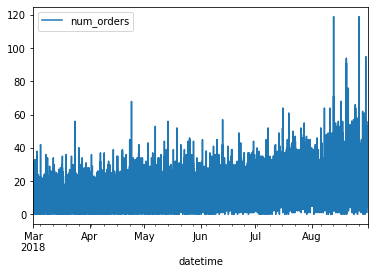

In [9]:
#построим график
df.plot()
plt.show()

Воспользуемся методом нахождения скользящего среднего с окном 100 заказов для сглаживания шумов и выявления общей тенденции.

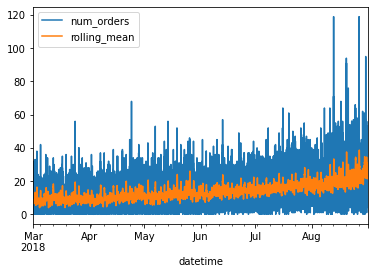

In [10]:
df['rolling_mean'] = df.rolling(50).mean()

df.plot()

plt.show()

На графике видно, что тренд с начала марта идет плавно на увеличение и ориентировочно с июня начинает увеличиваться еще больше

Чтобы лучше понимать временной ряд, разберём тренды и сезонность. Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

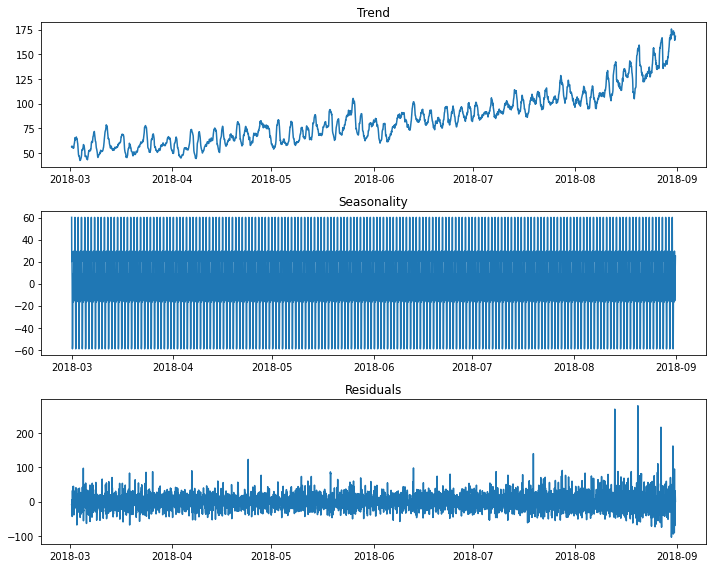

In [11]:
decomposed = seasonal_decompose(df_resampled)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

axes[0].plot(decomposed.trend)
axes[0].set_title('Trend')

axes[1].plot(decomposed.seasonal)
axes[1].set_title('Seasonality')

axes[2].plot(decomposed.resid)
axes[2].set_title('Residuals')

plt.tight_layout()

plt.show()

График тренда подтверждает наш вывод по анализу скользящего среднего: увеличение числа заказов с июня по конец августа. На графике сезонности ничего непонятно, необходимо подобрать подходящий масштаб. Остатки необъяснимы.

Для сезонности попробуем взять недельный график

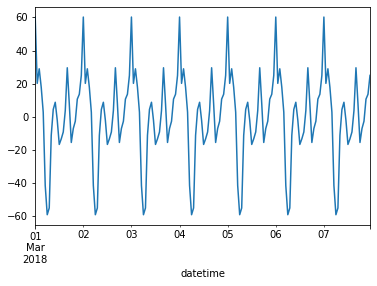

In [12]:
decomposed.seasonal['2018-03-01':'2018-03-7'].plot(ax=plt.gca())

plt.show()

На графике четко прослеживается дневная сезонность

## Обучение

Создадим признаки для горизонта прогнозирования

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Применим функцию с лагом 168 (24 часа * 7 дней в неделе) и окном 100 заказов для скользящего среднего

In [14]:
make_features(df_resampled, 168, 100)
df_resampled.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим пропуски

In [15]:
df_resampled = df_resampled.dropna()
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 172 entries, num_orders to rolling_mean
dtypes: float64(169), int64(3)
memory usage: 5.6 MB


Поделим на на выборки

In [16]:
train, valid = train_test_split(df_resampled, shuffle=False, test_size=0.2)


display(train.shape)
display(valid.shape)
display(train.index.min(), train.index.max())
display(valid.index.min(), valid.index.max())

(3398, 172)

(850, 172)

Timestamp('2018-03-08 00:00:00', freq='H')

Timestamp('2018-07-27 13:00:00', freq='H')

Timestamp('2018-07-27 14:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

In [17]:
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)


display(valid.shape)
display(test.shape)
display(valid.index.min(), valid.index.max())
display(test.index.min(), test.index.max())

(425, 172)

(425, 172)

Timestamp('2018-07-27 14:00:00', freq='H')

Timestamp('2018-08-14 06:00:00', freq='H')

Timestamp('2018-08-14 07:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

Выделим в выборках признаки и целевой признак

In [18]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

valid_features = valid.drop('num_orders', axis=1)
valid_target = valid['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Обучим модель линейной регрессии

In [19]:
%%time

model_lr = LinearRegression()
model_lr.fit(train_features, train_target)

predict_lr = model_lr.predict(valid_features)

rmse_lr = mse(valid_target, predict_lr, squared=False)
rmse_lr

CPU times: user 295 ms, sys: 311 ms, total: 606 ms
Wall time: 585 ms


29.1957243778893

Обучим CatBoost

In [20]:
#разобъем на фолды в хронологическом порядке
ts_cv = TimeSeriesSplit(n_splits=3)

In [21]:
%%time

model_cbr = CatBoostRegressor(loss_function='RMSE')
parameters = {'learning_rate':np.arange(0.1,1,0.2), 'depth': [6, 8, 9]}
catboost_grid = model_cbr.grid_search(parameters,
            Pool(train_features, train_target),
            cv=ts_cv,
            verbose=1000)

0:	learn: 71.1154510	test: 96.9005521	best: 96.9005521 (0)	total: 112ms	remaining: 1m 52s
1:	learn: 65.2691978	test: 90.1047915	best: 90.1047915 (1)	total: 155ms	remaining: 1m 17s
2:	learn: 60.0086728	test: 83.7807955	best: 83.7807955 (2)	total: 190ms	remaining: 1m 3s
3:	learn: 55.2541706	test: 77.9235854	best: 77.9235854 (3)	total: 226ms	remaining: 56.2s
4:	learn: 50.7548399	test: 72.0849810	best: 72.0849810 (4)	total: 269ms	remaining: 53.4s
5:	learn: 46.9360764	test: 67.5388224	best: 67.5388224 (5)	total: 304ms	remaining: 50.4s
6:	learn: 43.5602643	test: 63.3764650	best: 63.3764650 (6)	total: 347ms	remaining: 49.2s
7:	learn: 40.4522642	test: 59.2899191	best: 59.2899191 (7)	total: 384ms	remaining: 47.6s
8:	learn: 37.9596715	test: 56.0068294	best: 56.0068294 (8)	total: 420ms	remaining: 46.2s
9:	learn: 35.4872221	test: 52.7618532	best: 52.7618532 (9)	total: 461ms	remaining: 45.6s
10:	learn: 33.4410340	test: 50.0288788	best: 50.0288788 (10)	total: 497ms	remaining: 44.7s
11:	learn: 31.632

In [22]:
#оптимальные параметры
catboost_grid["params"]

{'depth': 6, 'learning_rate': 0.1}

In [23]:
%%time

#подставим оптимальный коэффициент и обучим
model_cbr = CatBoostRegressor(learning_rate=catboost_grid["params"]['learning_rate'],
                              depth=catboost_grid["params"]['depth'],
                              loss_function='RMSE',verbose=100)
model_cbr.fit(Pool(train_features, train_target))

predict_cbr = model_cbr.predict(valid_features)

rmse_cbr = mse(valid_target, predict_cbr, squared=False)
rmse_cbr

0:	learn: 34.0943671	total: 56.4ms	remaining: 56.3s
100:	learn: 16.6680131	total: 3.86s	remaining: 34.4s
200:	learn: 13.5033870	total: 7.56s	remaining: 30.1s
300:	learn: 11.2866560	total: 11.3s	remaining: 26.2s
400:	learn: 9.5880724	total: 15.2s	remaining: 22.8s
500:	learn: 8.0432717	total: 19.2s	remaining: 19.1s
600:	learn: 6.8722163	total: 22.9s	remaining: 15.2s
700:	learn: 5.8092364	total: 26.6s	remaining: 11.4s
800:	learn: 4.9416056	total: 30.3s	remaining: 7.54s
900:	learn: 4.1764058	total: 34.1s	remaining: 3.75s
999:	learn: 3.5591968	total: 37.7s	remaining: 0us
CPU times: user 37.8 s, sys: 169 ms, total: 38 s
Wall time: 39 s


30.145772839768966

Обучим LightGBM

In [24]:
%%time

model_lgbm = LGBMRegressor() 
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.1, 0.05, 0.01]
}
grid_search = GridSearchCV(model_lgbm, param_grid, cv=ts_cv)
grid_search.fit(train_features, train_target)
print(grid_search.best_params_)

{'learning_rate': 0.05, 'num_leaves': 10}
CPU times: user 1h 33min 43s, sys: 39.6 s, total: 1h 34min 22s
Wall time: 1h 34min 54s


In [25]:
%%time

model_lgbm = LGBMRegressor(learning_rate=.05, num_leaves=10)
model_lgbm.fit(train_features, train_target)
predict_lgbm = model_lgbm.predict(valid_features)
rmse_lgbm = mse(valid_target, predict_lgbm, squared=False)
display(rmse_lgbm)

30.392531534428617

CPU times: user 2min 4s, sys: 552 ms, total: 2min 4s
Wall time: 2min 5s


Вывод: лучшую метрику показала модель линейной регрессии - RMSE = 29.20

## Тестирование

Посмотрим значение метрики на тестовой выборке

In [26]:
test_predict_lr = model_lr.predict(test_features)
rmse_lr = mse(test_target, test_predict_lr, squared=False)
rmse_lr

34.63326987994327

1. Были загружены и предобработаны данные (очистка, заполнение, удаление лишних данных и т.д.)
2. Обучили на трейне и валидационных выборках 3 модели (две модели градиентного бустинга + линейная регрессия) и сравнили между собой
3. Выбрали лучшую модель и проверили ее на тестовой выборке.


Итого: наилучшей моделью стала модель линейной регрессии, которая на финальном тестировании показала RMSE 34.63.